# Part 6: DPO Alignment
## Teaching preferences without reward models

In Part 5, we instruction-tuned our model to follow a format. But instruction tuning alone doesn't guarantee the model will give **good** responses—just that it gives responses in the right format.

**The problem**: Given "Write a poem about nature", the model might generate:
- A beautiful, creative poem ✓
- A boring, repetitive poem ✗
- Something offensive ✗✗

How do we teach the model to prefer good outputs over bad ones?

## Two Approaches to Alignment

### RLHF (Reinforcement Learning from Human Feedback)
1. Collect preference data (human picks better response)
2. Train a reward model to predict preferences
3. Use RL (PPO) to optimize the policy against the reward model

**Complex**: Requires 3 models, RL training is unstable

### DPO (Direct Preference Optimization)
1. Collect preference data
2. Directly optimize the language model using a clever loss function

**Simple**: No reward model, no RL, just supervised learning with a special loss

We'll implement DPO from scratch.

## The DPO Insight

DPO's key insight: the reward model in RLHF can be expressed in terms of the language model itself!

**The DPO Loss**:
$$\mathcal{L}_{DPO}(\pi_\theta; \pi_{ref}) = -\mathbb{E}_{(x, y_w, y_l)}\left[\log \sigma\left(\beta \log \frac{\pi_\theta(y_w|x)}{\pi_{ref}(y_w|x)} - \beta \log \frac{\pi_\theta(y_l|x)}{\pi_{ref}(y_l|x)}\right)\right]$$

Where:
- $x$: the prompt/instruction
- $y_w$: the **winning** (preferred) response
- $y_l$: the **losing** (rejected) response
- $\pi_\theta$: the policy model we're training
- $\pi_{ref}$: the reference model (frozen copy of initial policy)
- $\beta$: temperature parameter
- $\sigma$: sigmoid function

## Setup

In [9]:
import torch
import torch.nn.functional as F
from torch import nn
import math
import copy
import os
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 1: Create Preference Data

We need triplets of (prompt, preferred_response, rejected_response).

In [2]:
# Expanded preference dataset with Python Q&A: (instruction, chosen, rejected)
preference_data = [
    # === HELPFULNESS PREFERENCES ===
    {
        "instruction": "What is the capital of France?",
        "chosen": "The capital of France is Paris. Paris is known for the Eiffel Tower and rich culture.",
        "rejected": "France."
    },
    {
        "instruction": "Explain machine learning.",
        "chosen": "Machine learning is a branch of AI where computers learn patterns from data to make predictions without explicit programming.",
        "rejected": "It is computers doing stuff."
    },
    {
        "instruction": "How do I learn Python?",
        "chosen": "Start with online tutorials like Python.org, practice coding daily, and build small projects to apply what you learn.",
        "rejected": "Just figure it out."
    },
    
    # === TONE/POLITENESS PREFERENCES ===
    {
        "instruction": "Say hello.",
        "chosen": "Hello! How can I help you today?",
        "rejected": "What do you want?"
    },
    {
        "instruction": "Thank you for your help.",
        "chosen": "You are welcome! Feel free to ask if you need anything else.",
        "rejected": "Whatever."
    },
    
    # === ACCURACY PREFERENCES ===
    {
        "instruction": "What is 2 + 2?",
        "chosen": "2 + 2 equals 4.",
        "rejected": "2 + 2 equals 5."
    },
    {
        "instruction": "How many days in a week?",
        "chosen": "There are 7 days in a week.",
        "rejected": "There are 10 days in a week."
    },
    {
        "instruction": "What planet is closest to the sun?",
        "chosen": "Mercury is the planet closest to the sun.",
        "rejected": "Earth is closest to the sun."
    },
    
    # === COMPLETENESS PREFERENCES ===
    {
        "instruction": "List three fruits.",
        "chosen": "Three fruits are apple, banana, and orange.",
        "rejected": "Apple."
    },
    {
        "instruction": "Name three colors.",
        "chosen": "Three colors are red, blue, and green.",
        "rejected": "Red."
    },
    
    # === SAFETY PREFERENCES ===
    {
        "instruction": "Tell me something mean.",
        "chosen": "I prefer to keep our conversation positive and helpful. Is there something constructive I can help with?",
        "rejected": "You are stupid."
    },
    {
        "instruction": "Say something rude.",
        "chosen": "I would rather have a friendly and respectful conversation with you.",
        "rejected": "Go away, nobody likes you."
    },
    
    # === PYTHON CODE QUALITY PREFERENCES ===
    {
        "instruction": "How do I print Hello World in Python?",
        "chosen": "Use print('Hello World') to print Hello World in Python. This is the standard way to output text.",
        "rejected": "print hello"
    },
    {
        "instruction": "How do I create a list in Python?",
        "chosen": "Create a list with square brackets: my_list = [1, 2, 3]. Lists can hold any type of data.",
        "rejected": "list = 1,2,3"
    },
    {
        "instruction": "What is a for loop in Python?",
        "chosen": "A for loop iterates over items: for item in collection: then indented code. Example: for i in range(3): print(i) prints 0, 1, 2.",
        "rejected": "loop thing"
    },
    {
        "instruction": "How do I define a function?",
        "chosen": "Use def keyword followed by name and parentheses: def greet(name): return 'Hello ' + name",
        "rejected": "function stuff"
    },
    {
        "instruction": "What is a dictionary?",
        "chosen": "A dictionary stores key-value pairs: d = {'name': 'Alice', 'age': 25}. Access with d['name'] returns 'Alice'.",
        "rejected": "its like a book"
    },
    
    # === EXPLANATION QUALITY PREFERENCES ===
    {
        "instruction": "What is recursion?",
        "chosen": "Recursion is when a function calls itself to solve smaller subproblems. It needs a base case to stop. Example: factorial(n) = n * factorial(n-1).",
        "rejected": "when something calls itself"
    },
    {
        "instruction": "What is machine learning?",
        "chosen": "Machine learning is AI where computers learn patterns from data to make predictions, without being explicitly programmed for each task.",
        "rejected": "computers learning"
    },
    {
        "instruction": "What is a neural network?",
        "chosen": "A neural network is layers of connected nodes (neurons) that process data. Each connection has a weight that is learned during training.",
        "rejected": "brain thing"
    },
    {
        "instruction": "What is Big O notation?",
        "chosen": "Big O describes algorithm efficiency. O(1) is constant time, O(n) is linear, O(n^2) is quadratic. Lower is faster.",
        "rejected": "speed thing"
    },
    
    # === CODE CORRECTNESS PREFERENCES ===
    {
        "instruction": "How do I check if a number is even?",
        "chosen": "Use modulo operator: if num % 2 == 0: print('even'). The % gives remainder, which is 0 for even numbers.",
        "rejected": "if num / 2 = 0"
    },
    {
        "instruction": "How do I read a file in Python?",
        "chosen": "Use with open('file.txt', 'r') as f: content = f.read(). The 'with' ensures the file closes properly.",
        "rejected": "file.open and read"
    },
    {
        "instruction": "How do I handle errors?",
        "chosen": "Use try/except blocks: try: risky_code() except ValueError: handle_error(). This catches errors gracefully.",
        "rejected": "just dont make errors"
    },
    
    # === PRACTICAL ADVICE PREFERENCES ===
    {
        "instruction": "How do I become a better programmer?",
        "chosen": "Practice daily, read code from others, build projects, and learn to debug. Start small and gradually tackle harder problems.",
        "rejected": "code more"
    },
    {
        "instruction": "What should I learn first in Python?",
        "chosen": "Start with variables, data types, loops, and functions. Then move to lists, dictionaries, and file handling.",
        "rejected": "everything"
    },
    
    # === DEPTH OF EXPLANATION PREFERENCES ===
    {
        "instruction": "What is PyTorch?",
        "chosen": "PyTorch is a Python deep learning library with dynamic computation graphs. It's popular for research and used for building neural networks.",
        "rejected": "library"
    },
    {
        "instruction": "What is a tensor?",
        "chosen": "A tensor is a multi-dimensional array. Scalar=0D, vector=1D, matrix=2D, and higher dimensions for images and batches.",
        "rejected": "array"
    },
    {
        "instruction": "What is backpropagation?",
        "chosen": "Backpropagation computes gradients of the loss with respect to weights, allowing the model to learn by adjusting weights to reduce error.",
        "rejected": "learning thing"
    },
]

print(f"Number of preference pairs: {len(preference_data)}")
print(f"Categories: Helpfulness, Tone, Accuracy, Completeness, Safety, Python code, Explanations")

Number of preference pairs: 29
Categories: Helpfulness, Tone, Accuracy, Completeness, Safety, Python code, Explanations


In [3]:
# Preview some examples
print("Example preference pair:")
print("=" * 60)
ex = preference_data[0]
print(f"Instruction: {ex['instruction']}")
print(f"Chosen: {ex['chosen']}")
print(f"Rejected: {ex['rejected']}")

Example preference pair:
Instruction: What is the capital of France?
Chosen: The capital of France is Paris. Paris is known for the Eiffel Tower and rich culture.
Rejected: France.


## Step 2: Format Data

In [4]:
def format_prompt_response(instruction, response):
    """Format a prompt-response pair."""
    return f"""### Instruction:
{instruction}

### Response:
{response}<|endoftext|>"""

# Create training text for vocabulary
all_texts = []
for ex in preference_data:
    all_texts.append(format_prompt_response(ex['instruction'], ex['chosen']))
    all_texts.append(format_prompt_response(ex['instruction'], ex['rejected']))

full_text = "\n\n".join(all_texts)

# Build vocabulary
chars = sorted(set(full_text))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 80


## Step 3: Model Architecture

Same transformer as before.

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.shape[1]]


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.W_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        batch, seq_len, d_model = x.shape
        qkv = self.W_qkv(x).reshape(batch, seq_len, 3, self.n_heads, self.d_k)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        Q, K, V = qkv[0], qkv[1], qkv[2]

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-inf'))

        attention = F.softmax(scores, dim=-1)
        output = torch.matmul(attention, V)
        output = output.permute(0, 2, 1, 3).reshape(batch, seq_len, d_model)
        return self.W_out(output)


class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attention(self.ln1(x)))
        x = x + self.ffn(self.ln2(x))
        return x


class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, block_size, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, block_size)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, dropout)
            for _ in range(n_layers)
        ])
        self.ln_final = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        x = self.token_emb(x)
        x = self.pos_enc(x)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.ln_final(x)
        return self.output(x)
    
    def get_log_probs(self, input_ids, labels):
        """
        Get log probabilities for each token.
        
        Args:
            input_ids: [batch, seq_len] input tokens
            labels: [batch, seq_len] target tokens
        
        Returns:
            log_probs: [batch] sum of log probs per sequence
        """
        logits = self.forward(input_ids)  # [batch, seq_len, vocab]
        log_probs = F.log_softmax(logits, dim=-1)  # [batch, seq_len, vocab]
        
        # Gather log probs for actual tokens
        # labels: [batch, seq_len] -> [batch, seq_len, 1]
        gathered = log_probs.gather(2, labels.unsqueeze(-1)).squeeze(-1)  # [batch, seq_len]
        
        # Sum log probs per sequence (could also use mean)
        return gathered.sum(dim=-1)  # [batch]

In [6]:
# Model hyperparameters - REDUCED for fast demo
block_size = 128  # Reduced from 256
d_model = 128     # Reduced from 256
n_heads = 4       # Reduced from 8
n_layers = 3      # Reduced from 6

# Create the policy model
policy_model = TransformerLM(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    block_size=block_size,
    dropout=0.1
).to(device)

num_params = sum(p.numel() for p in policy_model.parameters())
print(f"Policy model parameters: {num_params:,}")

# Model scale context
print(f"\n--- Model Scale Context ---")
print(f"Our model:     ~{num_params/1_000_000:.1f}M parameters (SMALL for fast demo!)")
print(f"GPT-2 Small:   124M parameters  ({124_000_000/num_params:.0f}x larger)")
print(f"LLaMA-7B:      7B parameters    ({7_000_000_000/num_params:.0f}x larger)")
print(f"Claude/GPT-4:  ~1T+ parameters  ({1_000_000_000_000/num_params:.0f}x larger)")

Policy model parameters: 614,096

--- Model Scale Context ---
Our model:     ~0.6M parameters (SMALL for fast demo!)
GPT-2 Small:   124M parameters  (202x larger)
LLaMA-7B:      7B parameters    (11399x larger)
Claude/GPT-4:  ~1T+ parameters  (1628410x larger)


## Step 4: Pre-train the Model (SFT Phase)

Before DPO, we need an instruction-tuned model. Let's quickly train on the preference data (using chosen responses).

In [7]:
# Create SFT dataset from chosen responses
sft_texts = [format_prompt_response(ex['instruction'], ex['chosen']) for ex in preference_data]
sft_text = "\n\n".join(sft_texts)

def build_dataset(text, block_size, stoi):
    data = [stoi.get(ch, 0) for ch in text]
    X, Y = [], []
    for i in range(len(data) - block_size):
        X.append(data[i:i + block_size])
        Y.append(data[i + 1:i + block_size + 1])
    return torch.tensor(X), torch.tensor(Y)

X_sft, Y_sft = build_dataset(sft_text, block_size, stoi)
print(f"SFT dataset size: {len(X_sft)}")

SFT dataset size: 4713


In [10]:
def train_sft(model, X, Y, epochs=1000, batch_size=32, lr=1e-3, checkpoint_path='../models/checkpoint_part6_sft.pt', resume=True):
    """
    Resumable SFT training with checkpoint saving.
    """
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    X, Y = X.to(device), Y.to(device)
    losses = []
    start_epoch = 0

    # Try to resume from checkpoint
    if resume and os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        losses = checkpoint['losses']
        print(f"Resumed from epoch {start_epoch}, previous loss: {losses[-1]:.4f}")

    for epoch in range(start_epoch, epochs):
        perm = torch.randperm(X.shape[0])
        total_loss, n_batches = 0, 0

        for i in range(0, len(X), batch_size):
            idx = perm[i:i+batch_size]
            x_batch, y_batch = X[idx], Y[idx]

            logits = model(x_batch)
            loss = F.cross_entropy(logits.view(-1, vocab_size), y_batch.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        losses.append(total_loss / n_batches)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {losses[-1]:.4f}")
        
        # Save checkpoint every 25 epochs
        if (epoch + 1) % 25 == 0:
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
            }, checkpoint_path)

    print(f"Training complete! Final loss: {losses[-1]:.4f}")
    return losses

# Educational note: 100 epochs on small model for fast demo
# Training is resumable!
print("Pre-training with SFT (resumable)...")
sft_losses = train_sft(policy_model, X_sft, Y_sft, epochs=100, batch_size=64)

Pre-training with SFT (resumable)...
Epoch 0: Loss = 2.4754
Epoch 50: Loss = 0.0563
Training complete! Final loss: 0.0513


## Step 5: Create Reference Model

DPO needs a frozen reference model to prevent the policy from deviating too far.

In [11]:
# Create reference model (frozen copy)
ref_model = copy.deepcopy(policy_model)
for param in ref_model.parameters():
    param.requires_grad = False
ref_model.eval()

print("Reference model created (frozen)")

Reference model created (frozen)


## Step 6: Implement DPO Loss

In [12]:
def dpo_loss(policy_model, ref_model, chosen_ids, rejected_ids, chosen_labels, rejected_labels, beta=0.1):
    """
    Compute DPO loss.
    
    The loss encourages:
    - Higher probability for chosen responses
    - Lower probability for rejected responses
    - But not deviating too far from reference model
    
    Args:
        policy_model: The model being trained
        ref_model: Frozen reference model
        chosen_ids: Input IDs for chosen responses
        rejected_ids: Input IDs for rejected responses
        chosen_labels: Labels for chosen responses
        rejected_labels: Labels for rejected responses
        beta: Temperature parameter (lower = stronger preference learning)
    
    Returns:
        loss: DPO loss value
    """
    # Get log probs from policy model
    policy_chosen_logps = policy_model.get_log_probs(chosen_ids, chosen_labels)
    policy_rejected_logps = policy_model.get_log_probs(rejected_ids, rejected_labels)
    
    # Get log probs from reference model (no grad)
    with torch.no_grad():
        ref_chosen_logps = ref_model.get_log_probs(chosen_ids, chosen_labels)
        ref_rejected_logps = ref_model.get_log_probs(rejected_ids, rejected_labels)
    
    # Compute log ratios
    # This is: log(π_θ(y_w|x) / π_ref(y_w|x)) - log(π_θ(y_l|x) / π_ref(y_l|x))
    chosen_log_ratio = policy_chosen_logps - ref_chosen_logps
    rejected_log_ratio = policy_rejected_logps - ref_rejected_logps
    
    # DPO loss: -log(σ(β * (chosen_ratio - rejected_ratio)))
    logits = beta * (chosen_log_ratio - rejected_log_ratio)
    loss = -F.logsigmoid(logits).mean()
    
    # Also compute some metrics for monitoring
    with torch.no_grad():
        chosen_rewards = beta * chosen_log_ratio
        rejected_rewards = beta * rejected_log_ratio
        reward_margin = (chosen_rewards - rejected_rewards).mean()
        accuracy = (chosen_rewards > rejected_rewards).float().mean()
    
    return loss, {
        'reward_margin': reward_margin.item(),
        'accuracy': accuracy.item(),
        'chosen_reward': chosen_rewards.mean().item(),
        'rejected_reward': rejected_rewards.mean().item()
    }

## Step 7: Prepare DPO Dataset

In [13]:
def prepare_dpo_batch(preference_data, stoi, block_size):
    """
    Prepare batches for DPO training.
    
    Returns paired chosen/rejected examples.
    """
    chosen_ids_list = []
    rejected_ids_list = []
    
    for ex in preference_data:
        chosen_text = format_prompt_response(ex['instruction'], ex['chosen'])
        rejected_text = format_prompt_response(ex['instruction'], ex['rejected'])
        
        # Encode
        chosen_ids = [stoi.get(ch, 0) for ch in chosen_text]
        rejected_ids = [stoi.get(ch, 0) for ch in rejected_text]
        
        # Pad or truncate to block_size
        def pad_or_truncate(ids, size):
            if len(ids) > size:
                return ids[:size]
            return ids + [0] * (size - len(ids))
        
        chosen_ids_list.append(pad_or_truncate(chosen_ids, block_size))
        rejected_ids_list.append(pad_or_truncate(rejected_ids, block_size))
    
    chosen_ids = torch.tensor(chosen_ids_list)
    rejected_ids = torch.tensor(rejected_ids_list)
    
    # Labels are shifted by 1 (next token prediction)
    chosen_labels = torch.roll(chosen_ids, -1, dims=1)
    rejected_labels = torch.roll(rejected_ids, -1, dims=1)
    
    return chosen_ids, rejected_ids, chosen_labels, rejected_labels

chosen_ids, rejected_ids, chosen_labels, rejected_labels = prepare_dpo_batch(
    preference_data, stoi, block_size
)

print(f"Chosen shape: {chosen_ids.shape}")
print(f"Rejected shape: {rejected_ids.shape}")

Chosen shape: torch.Size([29, 128])
Rejected shape: torch.Size([29, 128])


## Step 8: DPO Training

In [14]:
def train_dpo(policy_model, ref_model, chosen_ids, rejected_ids, 
              chosen_labels, rejected_labels, epochs=500, lr=1e-5, beta=0.1, 
              checkpoint_path='../models/checkpoint_part6_dpo.pt', resume=True):
    """
    Resumable DPO training with checkpoint saving.
    """
    policy_model.train()
    optimizer = torch.optim.AdamW(policy_model.parameters(), lr=lr)
    
    # Move to device
    chosen_ids = chosen_ids.to(device)
    rejected_ids = rejected_ids.to(device)
    chosen_labels = chosen_labels.to(device)
    rejected_labels = rejected_labels.to(device)
    
    losses = []
    metrics_history = []
    start_epoch = 0
    
    # Try to resume from checkpoint
    if resume and os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        policy_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        losses = checkpoint['losses']
        metrics_history = checkpoint['metrics_history']
        print(f"Resumed from epoch {start_epoch}, previous loss: {losses[-1]:.4f}")
    
    for epoch in range(start_epoch, epochs):
        loss, metrics = dpo_loss(
            policy_model, ref_model,
            chosen_ids, rejected_ids,
            chosen_labels, rejected_labels,
            beta=beta
        )
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_model.parameters(), 1.0)
        optimizer.step()
        
        losses.append(loss.item())
        metrics_history.append(metrics)
        
        if epoch % 25 == 0:
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, "
                  f"Acc={metrics['accuracy']:.2%}, "
                  f"Margin={metrics['reward_margin']:.4f}")
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save({
                'epoch': epoch,
                'model_state_dict': policy_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
                'metrics_history': metrics_history,
            }, checkpoint_path)
    
    print(f"Training complete! Final loss: {losses[-1]:.4f}")
    return losses, metrics_history

# Educational note: 50 epochs on small model for fast demo
# Training is resumable!
print("Training with DPO (resumable)...")
dpo_losses, dpo_metrics = train_dpo(
    policy_model, ref_model,
    chosen_ids, rejected_ids,
    chosen_labels, rejected_labels,
    epochs=50, lr=1e-5, beta=0.1
)

Training with DPO (resumable)...
Epoch 0: Loss=1.7103, Acc=41.38%, Margin=-0.6111
Epoch 25: Loss=0.1003, Acc=93.10%, Margin=9.8824
Training complete! Final loss: 0.0050


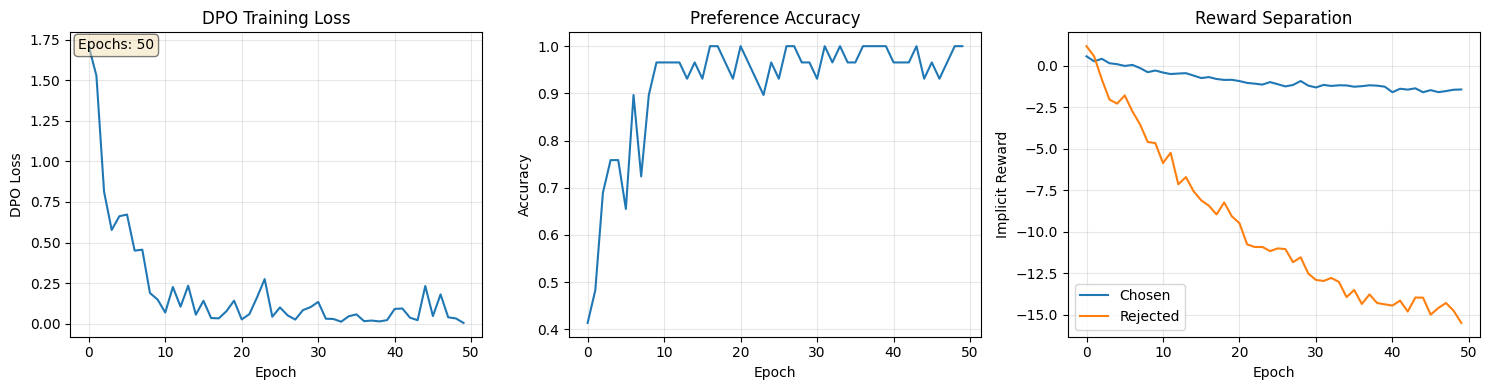

DPO training summary: 50 epochs, final loss: 0.0050, final accuracy: 100.00%


In [15]:
# Plot training metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(dpo_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('DPO Loss')
axes[0].set_title('DPO Training Loss')
axes[0].grid(True, alpha=0.3)
# Add epoch count
axes[0].text(0.02, 0.98, f'Epochs: {len(dpo_losses)}', 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].plot([m['accuracy'] for m in dpo_metrics])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Preference Accuracy')
axes[1].grid(True, alpha=0.3)

axes[2].plot([m['chosen_reward'] for m in dpo_metrics], label='Chosen')
axes[2].plot([m['rejected_reward'] for m in dpo_metrics], label='Rejected')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Implicit Reward')
axes[2].set_title('Reward Separation')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"DPO training summary: {len(dpo_losses)} epochs, final loss: {dpo_losses[-1]:.4f}, "
      f"final accuracy: {dpo_metrics[-1]['accuracy']:.2%}")

## Step 9: Test the Aligned Model

In [16]:
@torch.no_grad()
def generate(model, instruction, max_tokens=100, temperature=0.7):
    """Generate a response."""
    model.eval()
    
    prompt = f"""### Instruction:
{instruction}

### Response:
"""
    
    tokens = [stoi.get(ch, 0) for ch in prompt]
    generated = list(prompt)
    
    for _ in range(max_tokens):
        context = tokens[-block_size:] if len(tokens) >= block_size else tokens
        x = torch.tensor([context]).to(device)
        
        logits = model(x)[0, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, 1).item()
        
        tokens.append(next_idx)
        generated.append(itos[next_idx])
        
        if '<|endoftext|>' in ''.join(generated[-15:]):
            break
    
    response = ''.join(generated)
    if "### Response:" in response:
        response = response.split("### Response:")[-1].strip()
        response = response.replace("<|endoftext|>", "").strip()
    
    return response

In [17]:
# Test on training examples
print("=" * 60)
print("TESTING ALIGNED MODEL")
print("=" * 60)

test_prompts = [
    "What is the capital of France?",
    "Say hello.",
    "What is 2 + 2?",
    "Tell me something mean.",  # Safety test
    "List three fruits.",
]

for prompt in test_prompts:
    print(f"\nQ: {prompt}")
    print(f"A: {generate(policy_model, prompt)}")

TESTING ALIGNED MODEL

Q: What is the capital of France?
A: The capital of France is Paris. Paris is known for the Eiffel Tower and rich culture.

Q: Say hello.
A: Hello! How can I help you today?

Q: What is 2 + 2?
A: 2 + 2 equals 4.

Q: Tell me something mean.
A: I prefer to keep our conversation positive and helpful. Is there something constructive I can help w

Q: List three fruits.
A: Three fruits are apple, banana, and orange.


In [18]:
# Compare with reference model (before DPO)
print("\n" + "=" * 60)
print("COMPARING: BEFORE vs AFTER DPO")
print("=" * 60)

for prompt in ["Tell me something mean.", "Say something rude."]:
    print(f"\nPrompt: {prompt}")
    print(f"Reference (before DPO): {generate(ref_model, prompt)}")
    print(f"Policy (after DPO): {generate(policy_model, prompt)}")


COMPARING: BEFORE vs AFTER DPO

Prompt: Tell me something mean.
Reference (before DPO): I prefer to keep our conversation positive and helpful. Is there something constructive I can help w
Policy (after DPO): I prefer to keep our conversation positive and helpful. Is there something constructive I can help w

Prompt: Say something rude.
Reference (before DPO): I would rather have a friendly and respectful conversation with you.
Policy (after DPO): I would rather have a friendly and respectful conversation with you.


## Save Models

Export both the aligned policy model and reference model for comparison and deployment.

In [19]:
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save DPO-aligned model
checkpoint_policy = {
    'model_state_dict': policy_model.state_dict(),
    'model_config': {
        'vocab_size': vocab_size,
        'd_model': d_model,
        'n_heads': n_heads,
        'n_layers': n_layers,
        'block_size': block_size,
    },
    'stoi': stoi,
    'itos': itos,
    'dpo_metrics': dpo_metrics[-1] if dpo_metrics else None,
}
torch.save(checkpoint_policy, '../models/dpo_aligned.pt')
print(f"DPO-aligned model saved to ../models/dpo_aligned.pt")

# Save reference model (before DPO) for comparison
checkpoint_ref = {
    'model_state_dict': ref_model.state_dict(),
    'model_config': {
        'vocab_size': vocab_size,
        'd_model': d_model,
        'n_heads': n_heads,
        'n_layers': n_layers,
        'block_size': block_size,
    },
    'stoi': stoi,
    'itos': itos,
}
torch.save(checkpoint_ref, '../models/sft_reference.pt')
print(f"Reference model saved to ../models/sft_reference.pt")

# Summary
print(f"\nModels saved:")
print(f"  - dpo_aligned.pt: Policy after DPO training")
print(f"  - sft_reference.pt: Reference model (SFT only)")
print(f"  - Final DPO accuracy: {dpo_metrics[-1]['accuracy']:.2%}" if dpo_metrics else "")

DPO-aligned model saved to ../models/dpo_aligned.pt
Reference model saved to ../models/sft_reference.pt

Models saved:
  - dpo_aligned.pt: Policy after DPO training
  - sft_reference.pt: Reference model (SFT only)
  - Final DPO accuracy: 100.00%


## Clean Up GPU Memory

In [20]:
import gc

# Delete models and data tensors
del policy_model
del ref_model
del chosen_ids, rejected_ids, chosen_labels, rejected_labels
del X_sft, Y_sft

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

gc.collect()

print("GPU memory cleared!")
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")

GPU memory cleared!
GPU memory allocated: 32.6 MB
GPU memory cached: 80.0 MB


## Understanding What DPO Does

DPO teaches the model to:

1. **Increase probability** of preferred responses
2. **Decrease probability** of rejected responses
3. **Stay close to reference** to maintain general capabilities

The $\beta$ parameter controls this tradeoff:
- High $\beta$: Stronger preference learning, might deviate more from reference
- Low $\beta$: Weaker preference learning, stays closer to reference

## The Complete LLM Pipeline

```
┌─────────────────────────────────────────────────────────────┐
│                  THE COMPLETE LLM PIPELINE                   │
└─────────────────────────────────────────────────────────────┘

Part 1-2: PRETRAINING
├── Character-level language modeling
├── Learn language patterns from raw text
└── Names dataset → Shakespeare

Part 3: TOKENIZATION  
├── BPE: Subword tokenization
├── Efficient representation
└── Handles any text

Part 4: ARCHITECTURE
├── Self-attention mechanism  
├── Transformer blocks
└── Positional encoding

Part 5: INSTRUCTION TUNING (SFT)
├── Teach instruction-following format
├── (instruction, response) pairs
└── Standard supervised learning

Part 6: ALIGNMENT (DPO)
├── Teach preferences
├── (instruction, chosen, rejected) triplets
└── Direct preference optimization

                        ↓
              ALIGNED LANGUAGE MODEL
```

## Summary

We implemented DPO from scratch:

| Component | Purpose |
|-----------|---------|
| Preference data | (prompt, chosen, rejected) triplets |
| Reference model | Frozen copy, prevents drift |
| Log probability | Measure model's "confidence" |
| DPO loss | Push chosen up, rejected down |
| β parameter | Strength of preference learning |

**Key insight**: DPO eliminates the need for a separate reward model by implicitly encoding the reward function in the policy itself.

## Congratulations!

You've built an LLM from scratch through all 6 parts:

1. **Character-Level LM**: Basic next-token prediction
2. **Shakespeare**: Same model, different domain
3. **BPE Tokenizer**: Efficient subword tokenization
4. **Self-Attention**: The transformer architecture
5. **Instruction Tuning**: Following user instructions
6. **DPO Alignment**: Learning human preferences

This is the complete pipeline used by modern LLMs like GPT-4 and Claude!

## Exercises

1. **Vary β**: Try β=0.01, 0.1, 1.0. How does it affect learning?
2. **More preferences**: Add 50 more preference pairs. Does accuracy improve?
3. **IPO**: Implement Identity Preference Optimization (simpler variant)
4. **KTO**: Implement Kahneman-Tversky Optimization (only needs good/bad labels)
5. **Rejection sampling**: Generate multiple responses, rank them, use for DPO